In [1]:
import numpy as np
import pandas as pd
import random
from scipy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys, argparse
import multiprocessing as mp
import missingno

# machine learning
import sklearn.cluster
import sklearn
import sklearn.preprocessing
import sklearn.decomposition
from sklearn.model_selection import train_test_split

###1. Load Data and Splot Data
from keras.models import Sequential 
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

#--- custom libs
wdir = "/work/kaggle/molecules/src"
if wdir:
    sys.path.insert(0, wdir)
import sfuncs as sff
import funcs as ff

plt.style.use('dark_background')

Using TensorFlow backend.


# > Descriptores de la distribucion espacial de los átomos
# entre sí (en terminos de distancia y distribuciones angulares)

In [2]:
df = pd.read_csv("../data/postproc/descriptors_sample.csv", sep=';')

In [3]:
df.columns

Index(['Unnamed: 0', 'molecule_name', 'atom_index', 'desc_g2ang_00',
       'desc_g2ang_01', 'desc_g2ang_02', 'desc_g2ang_03', 'desc_g2ang_04',
       'desc_g2ang_05', 'desc_g2rad_00', 'desc_g2rad_01', 'desc_g2rad_02',
       'desc_g2rad_03'],
      dtype='object')

In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [5]:
df.head()

molecule_name  atom_index  desc_g2ang_00  desc_g2ang_01  desc_g2ang_02  \
0  dsgdb9nsd_073799           0       0.547233       0.029197       6.160965   
1  dsgdb9nsd_073799           1       0.094606       0.000555       7.521452   
2  dsgdb9nsd_073799           2       0.091354       0.000446       7.452496   
3  dsgdb9nsd_073799           3       0.548031       0.029286       6.247297   
4  dsgdb9nsd_073799           4       0.086203       0.000814       9.040215   

   desc_g2ang_03  desc_g2ang_04  desc_g2ang_05  desc_g2rad_00  desc_g2rad_01  \
0       2.874391      48.005857      21.877733       2.930076       3.070760   
1       1.480662      81.585363      36.027836       3.222217       6.688551   
2       1.438356      90.420206      40.950256       3.064127       9.215784   
3       2.903426      57.968340      25.731346       2.928051       3.225681   
4       2.268404      85.743853      45.369535       4.261345       6.875405   

   desc_g2rad_02  desc_g2rad_03  
0       4.405743       3.178821  
1       5.392217       0.347580  
2       4.079353       0.014046  
3       6.440143       1.774062  
4       3.627894       0.844526

# > Mulliken charges

In [6]:
df_mulliken = pd.read_csv("../data/mulliken_charges.csv", sep=',')

In [7]:
df_mulliken.head(10)

molecule_name  atom_index  mulliken_charge
0  dsgdb9nsd_000001           0        -0.535689
1  dsgdb9nsd_000001           1         0.133921
2  dsgdb9nsd_000001           2         0.133922
3  dsgdb9nsd_000001           3         0.133923
4  dsgdb9nsd_000001           4         0.133923
5  dsgdb9nsd_000002           0        -0.707143
6  dsgdb9nsd_000002           1         0.235712
7  dsgdb9nsd_000002           2         0.235712
8  dsgdb9nsd_000002           3         0.235720
9  dsgdb9nsd_000003           0        -0.589706

In [8]:
df_struct = pd.read_csv("../data/structures.csv", sep=',')
df_struct.head()

molecule_name  atom_index atom         x         y         z
0  dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001
1  dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976
2  dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277
3  dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644
4  dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397

In [9]:
#%pdb

In [10]:
df_mulliken.columns.values

array(['molecule_name', 'atom_index', 'mulliken_charge'], dtype=object)

In [11]:
"molecule_name" in df.columns, "molecule_name" in df_mulliken.columns

(True, True)

In [12]:
df_merge = pd.merge(df, df_mulliken, 
    how="left", 
    on=["molecule_name", "atom_index"])
df_merge = pd.merge(df_merge, df_struct[["molecule_name", "atom_index", "atom"]], 
    how='left', 
    on=["molecule_name", "atom_index"])

In [13]:
del df_mulliken, df_struct

In [14]:
(~df_merge["mulliken_charge"].isna()).nonzero()[0].size / df_merge.shape[0]

/home/jim/anaconda/envs/kgg_mole/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """Entry point for launching an IPython kernel.


0.6555683024919076

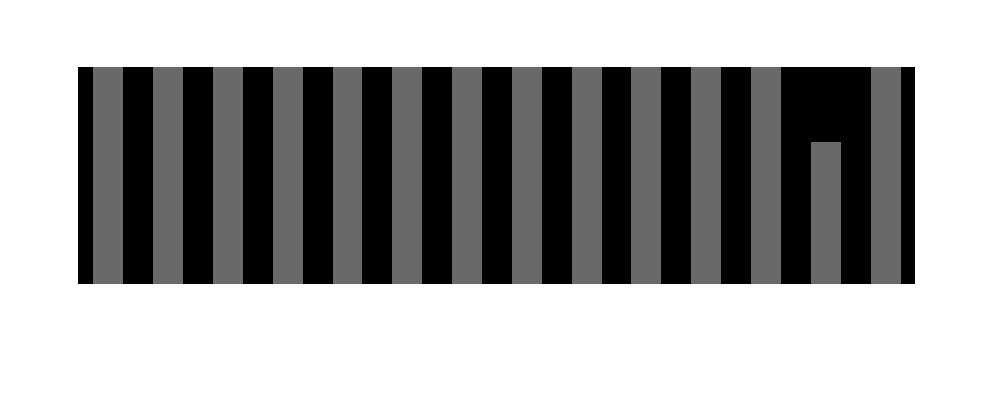

In [15]:
missingno.bar(df_merge, figsize=(15,4))

In [16]:
df_merge.dropna(axis=0, how='any', subset=["mulliken_charge",], inplace=True)

In [17]:
df_merge.reset_index(drop=True, inplace=True)
df_merge.head(15)

molecule_name  atom_index  desc_g2ang_00  desc_g2ang_01  desc_g2ang_02  \
0   dsgdb9nsd_017630           0       0.547949       0.028633       7.194091   
1   dsgdb9nsd_017630           1       0.241922       0.003339       8.757507   
2   dsgdb9nsd_017630           2       0.333929       0.002805       4.685400   
3   dsgdb9nsd_017630           3       0.239345       0.003175       8.531849   
4   dsgdb9nsd_017630           4       0.332514       0.002708       4.691544   
5   dsgdb9nsd_017630           5       0.249045       0.003569       8.438177   
6   dsgdb9nsd_017630           6       0.412580       0.012223       6.882280   
7   dsgdb9nsd_017630           7       0.294752       0.004150       6.226456   
8   dsgdb9nsd_017630           8       0.204288       0.002697       5.070745   
9   dsgdb9nsd_017630           9       0.205319       0.002747       5.242483   
10  dsgdb9nsd_017630          10       0.201256       0.002786       5.304461   
11  dsgdb9nsd_017630          11       0.172722       0.000579       5.069261   
12  dsgdb9nsd_017630          12       0.302460       0.000566       3.499560   
13  dsgdb9nsd_017630          13       0.171782       0.000557       5.289271   
14  dsgdb9nsd_017630          14       0.301996       0.000548       3.414977   

    desc_g2ang_03  desc_g2ang_04  desc_g2ang_05  desc_g2rad_00  desc_g2rad_01  \
0        3.249508      49.571979      24.492797       3.001572       4.125113   
1        2.760895      68.680336      36.980874       4.010415       5.631628   
2        0.947778      56.289402      15.987486       1.638641       4.861539   
3        2.655352      76.493828      41.014486       3.849984       8.122131   
4        0.979281      58.184220      17.005142       1.637393       5.258157   
5        2.544136      66.661271      34.315206       3.819794       5.990429   
6        2.636163      48.479012      21.831708       3.385609       2.682549   
7        1.530729      49.111491      15.841633       2.644295       3.578587   
8        0.522986      40.373579       6.769982       1.800568       2.781075   
9        0.571870      46.704413       9.955377       1.808596       3.632109   
10       0.608282      47.126864      10.326532       1.836168       3.903655   
11       0.625274      61.867333      15.576761       1.097501       7.137028   
12       0.360387      50.180153      10.153141       0.748223       4.626119   
13       0.707514      71.776857      21.327982       1.096418       8.547974   
14       0.342176      49.841973       9.394589       0.737381       4.591038   

    desc_g2rad_02  desc_g2rad_03  mulliken_charge atom  
0        2.274815       2.335652        -0.407773    C  
1        3.144253       0.431052         0.117649    C  
2        5.175452       0.771365        -0.426036    O  
3        2.223539       0.016529         0.068147    C  
4        5.052657       0.650426        -0.429458    O  
5        2.434290       0.844743         0.012589    C  
6        4.089985       1.728560        -0.235162    C  
7        2.489373       2.026450        -0.325393    N  
8        2.767152       1.684364         0.121494    H  
9        2.755012       2.162122         0.135998    H  
10       2.437441       2.630831         0.103203    H  
11       2.674112       1.325034         0.081392    H  
12       5.254099       1.291286         0.278311    H  
13       3.318917       0.053009         0.069190    H  
14       4.676210       1.494685         0.286031    H

In [18]:
df_merge.shape

(153717, 14)

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_merge.drop(["molecule_name", "atom_index", "mulliken_charge", "atom"], axis=1),
    df_merge[["mulliken_charge",]],
    train_size=0.75
    )

In [20]:
X_train.shape, Y_train.shape

((115287, 10), (115287, 1))

In [21]:
X_train.describe()

desc_g2ang_00  desc_g2ang_01  desc_g2ang_02  desc_g2ang_03  \
count  115287.000000   1.152870e+05  115287.000000   1.152870e+05   
mean        0.231394   4.003192e-03       5.201915   1.093482e+00   
std         0.109828   6.606053e-03       1.642542   9.390170e-01   
min         0.038662   3.050931e-14       1.308759   2.512248e-09   
25%         0.180939   7.000997e-04       4.195628   4.255562e-01   
50%         0.200200   1.685081e-03       4.916233   5.699552e-01   
75%         0.258858   2.881908e-03       6.382538   1.899653e+00   
max         0.755744   6.214248e-02      11.145677   3.842683e+00   

       desc_g2ang_04  desc_g2ang_05  desc_g2rad_00  desc_g2rad_01  \
count  115287.000000  115287.000000  115287.000000  115287.000000   
mean       48.596882      15.489464       2.075818       3.992091   
std        15.261019      10.361732       0.996226       1.567291   
min         5.663397       0.000008       0.649324       0.000443   
25%        38.269406       7.573722       1.293315       2.883342   
50%        47.879662      12.089077       1.827368       3.915280   
75%        58.401881      22.466063       3.006172       5.012506   
max       128.690815      68.633508       4.550532      12.093716   

       desc_g2rad_02  desc_g2rad_03  
count  115287.000000   1.152870e+05  
mean        3.576170   1.399016e+00  
std         1.271670   9.070643e-01  
min         0.000001   2.550361e-14  
25%         2.649143   6.530784e-01  
50%         3.531750   1.349612e+00  
75%         4.437512   2.025149e+00  
max         9.109272   5.598738e+00

In [22]:
scl_mean = X_train.mean(axis=0)
X_train_cent = X_train - scl_mean
scl_norm = np.max(X_train_cent.abs().max())

X_train_norm = pd.DataFrame(X_train_cent / scl_norm, dtype=np.float32)

In [23]:
X_train_norm.describe()

desc_g2ang_00  desc_g2ang_01  desc_g2ang_02  desc_g2ang_03  \
count   1.152870e+05   1.152870e+05   1.152870e+05   1.152870e+05   
mean    5.816373e-13   8.078296e-15  -2.843560e-12  -8.272175e-12   
std     1.371237e-03   8.247881e-05   2.050770e-02   1.172395e-02   
min    -2.406317e-03  -4.998121e-05  -4.860737e-02  -1.365249e-02   
25%    -6.299486e-04  -4.124022e-05  -1.256384e-02  -8.339279e-03   
50%    -3.894641e-04  -2.894239e-05  -3.566832e-03  -6.536410e-03   
75%     3.428991e-04  -1.399961e-05   1.474048e-02   1.006532e-02   
max     6.546685e-03   7.258888e-04   7.420989e-02   3.432471e-02   

       desc_g2ang_04  desc_g2ang_05  desc_g2rad_00  desc_g2rad_01  \
count   1.152870e+05   1.152870e+05   1.152870e+05   1.152870e+05   
mean   -1.013341e-10  -8.272175e-12  -4.329967e-12   7.238154e-12   
std     1.905390e-01   1.293697e-01   1.243822e-02   1.956816e-02   
min    -5.360392e-01  -1.933911e-01  -1.781027e-02  -4.983708e-02   
25%    -1.289421e-01  -9.883073e-02  -9.769819e-03  -1.384311e-02   
50%    -8.954738e-03  -4.245499e-02  -3.101981e-03  -9.590053e-04   
75%     1.224187e-01   8.710521e-02   1.161579e-02   1.274023e-02   
max     1.000000e+00   6.635215e-01   3.089765e-02   1.011515e-01   

       desc_g2rad_02  desc_g2rad_03  
count   1.152870e+05   1.152870e+05  
mean   -3.942209e-12   2.585055e-12  
std     1.587723e-02   1.132501e-02  
min    -4.464969e-02  -1.746719e-02  
25%    -1.157425e-02  -9.313286e-03  
50%    -5.546044e-04  -6.168237e-04  
75%     1.075415e-02   7.817480e-03  
max     6.908265e-02   5.243496e-02

In [24]:
# let's try w a "random forest"
# Inspired from:
# https://www.kaggle.com/borisdee/predicting-mulliken-charges-with-acsf-descriptors/notebook
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
import lightgbm

# > Random Forest

In [28]:
data_train = lightgbm.Dataset(X_train_norm, label=Y_train)
data_test  = lightgbm.Dataset((X_test - scl_mean)/scl_norm, label=Y_test)

# > Feature importance

In [47]:
parameters = {
    'application': 'regression',
    'objective': 'regression',
    'metric': 'mae',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = lightgbm.train(parameters,
                       data_train,
                       valid_sets = data_test,
                       num_boost_round = 5000,
                       early_stopping_rounds = 100)

[1]	valid_0's l1: 0.18178
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l1: 0.173424
[3]	valid_0's l1: 0.165514
[4]	valid_0's l1: 0.158064
[5]	valid_0's l1: 0.151671
[6]	valid_0's l1: 0.144689
[7]	valid_0's l1: 0.138297
[8]	valid_0's l1: 0.132433
[9]	valid_0's l1: 0.127039
[10]	valid_0's l1: 0.121488
[11]	valid_0's l1: 0.116525
[12]	valid_0's l1: 0.111504
[13]	valid_0's l1: 0.107174
[14]	valid_0's l1: 0.10264
[15]	valid_0's l1: 0.0987103
[16]	valid_0's l1: 0.0947562
[17]	valid_0's l1: 0.091245
[18]	valid_0's l1: 0.0881212
[19]	valid_0's l1: 0.0845426
[20]	valid_0's l1: 0.0812624
[21]	valid_0's l1: 0.0785917
[22]	valid_0's l1: 0.075852
[23]	valid_0's l1: 0.073082
[24]	valid_0's l1: 0.0712436
[25]	valid_0's l1: 0.0687971
[26]	valid_0's l1: 0.0662207
[27]	valid_0's l1: 0.0645307
[28]	valid_0's l1: 0.0627062
[29]	valid_0's l1: 0.0615163
[30]	valid_0's l1: 0.0594122
[31]	valid_0's l1: 0.0574736
[32]	valid_0's l1: 0.0559026
[33]	valid_0's l1: 0.0541463
[34]	val

[280]	valid_0's l1: 0.0238439
[281]	valid_0's l1: 0.0238401
[282]	valid_0's l1: 0.023829
[283]	valid_0's l1: 0.023829
[284]	valid_0's l1: 0.0238274
[285]	valid_0's l1: 0.0238244
[286]	valid_0's l1: 0.023817
[287]	valid_0's l1: 0.0237982
[288]	valid_0's l1: 0.0237687
[289]	valid_0's l1: 0.0237611
[290]	valid_0's l1: 0.0237475
[291]	valid_0's l1: 0.0237309
[292]	valid_0's l1: 0.0237169
[293]	valid_0's l1: 0.0237114
[294]	valid_0's l1: 0.0236937
[295]	valid_0's l1: 0.0236736
[296]	valid_0's l1: 0.0236672
[297]	valid_0's l1: 0.0236534
[298]	valid_0's l1: 0.0236485
[299]	valid_0's l1: 0.0236471
[300]	valid_0's l1: 0.0236427
[301]	valid_0's l1: 0.023611
[302]	valid_0's l1: 0.0235911
[303]	valid_0's l1: 0.0235749
[304]	valid_0's l1: 0.0235499
[305]	valid_0's l1: 0.0235399
[306]	valid_0's l1: 0.0235113
[307]	valid_0's l1: 0.0235073
[308]	valid_0's l1: 0.0234919
[309]	valid_0's l1: 0.0234822
[310]	valid_0's l1: 0.0234785
[311]	valid_0's l1: 0.0234544
[312]	valid_0's l1: 0.0234372
[313]	valid_0'

[555]	valid_0's l1: 0.0214774
[556]	valid_0's l1: 0.0214676
[557]	valid_0's l1: 0.0214583
[558]	valid_0's l1: 0.0214541
[559]	valid_0's l1: 0.0214464
[560]	valid_0's l1: 0.0214434
[561]	valid_0's l1: 0.0214366
[562]	valid_0's l1: 0.0214327
[563]	valid_0's l1: 0.0214311
[564]	valid_0's l1: 0.0214242
[565]	valid_0's l1: 0.0214228
[566]	valid_0's l1: 0.0214148
[567]	valid_0's l1: 0.0214109
[568]	valid_0's l1: 0.0213989
[569]	valid_0's l1: 0.0213899
[570]	valid_0's l1: 0.0213876
[571]	valid_0's l1: 0.0213831
[572]	valid_0's l1: 0.0213799
[573]	valid_0's l1: 0.0213734
[574]	valid_0's l1: 0.0213713
[575]	valid_0's l1: 0.0213644
[576]	valid_0's l1: 0.0213651
[577]	valid_0's l1: 0.0213591
[578]	valid_0's l1: 0.0213461
[579]	valid_0's l1: 0.0213403
[580]	valid_0's l1: 0.021339
[581]	valid_0's l1: 0.0213401
[582]	valid_0's l1: 0.0213358
[583]	valid_0's l1: 0.0213298
[584]	valid_0's l1: 0.0213274
[585]	valid_0's l1: 0.0213274
[586]	valid_0's l1: 0.0213261
[587]	valid_0's l1: 0.0213152
[588]	valid

[829]	valid_0's l1: 0.0205012
[830]	valid_0's l1: 0.0204976
[831]	valid_0's l1: 0.0204966
[832]	valid_0's l1: 0.0204907
[833]	valid_0's l1: 0.0204851
[834]	valid_0's l1: 0.0204809
[835]	valid_0's l1: 0.0204808
[836]	valid_0's l1: 0.0204731
[837]	valid_0's l1: 0.0204719
[838]	valid_0's l1: 0.0204684
[839]	valid_0's l1: 0.0204659
[840]	valid_0's l1: 0.0204607
[841]	valid_0's l1: 0.0204598
[842]	valid_0's l1: 0.0204584
[843]	valid_0's l1: 0.0204507
[844]	valid_0's l1: 0.0204489
[845]	valid_0's l1: 0.0204477
[846]	valid_0's l1: 0.0204439
[847]	valid_0's l1: 0.0204369
[848]	valid_0's l1: 0.0204281
[849]	valid_0's l1: 0.0204258
[850]	valid_0's l1: 0.0204226
[851]	valid_0's l1: 0.0204159
[852]	valid_0's l1: 0.0204132
[853]	valid_0's l1: 0.0204121
[854]	valid_0's l1: 0.0204104
[855]	valid_0's l1: 0.0204
[856]	valid_0's l1: 0.020399
[857]	valid_0's l1: 0.0203987
[858]	valid_0's l1: 0.0203894
[859]	valid_0's l1: 0.0203883
[860]	valid_0's l1: 0.0203826
[861]	valid_0's l1: 0.0203806
[862]	valid_0'

[1102]	valid_0's l1: 0.019854
[1103]	valid_0's l1: 0.0198523
[1104]	valid_0's l1: 0.0198479
[1105]	valid_0's l1: 0.0198452
[1106]	valid_0's l1: 0.0198446
[1107]	valid_0's l1: 0.0198399
[1108]	valid_0's l1: 0.0198347
[1109]	valid_0's l1: 0.0198329
[1110]	valid_0's l1: 0.0198324
[1111]	valid_0's l1: 0.0198315
[1112]	valid_0's l1: 0.0198267
[1113]	valid_0's l1: 0.0198214
[1114]	valid_0's l1: 0.0198203
[1115]	valid_0's l1: 0.0198198
[1116]	valid_0's l1: 0.0198184
[1117]	valid_0's l1: 0.0198136
[1118]	valid_0's l1: 0.0198072
[1119]	valid_0's l1: 0.0198062
[1120]	valid_0's l1: 0.0198055
[1121]	valid_0's l1: 0.0198056
[1122]	valid_0's l1: 0.0198023
[1123]	valid_0's l1: 0.0198002
[1124]	valid_0's l1: 0.0197976
[1125]	valid_0's l1: 0.0197957
[1126]	valid_0's l1: 0.019792
[1127]	valid_0's l1: 0.0197903
[1128]	valid_0's l1: 0.0197887
[1129]	valid_0's l1: 0.0197885
[1130]	valid_0's l1: 0.019783
[1131]	valid_0's l1: 0.0197822
[1132]	valid_0's l1: 0.0197788
[1133]	valid_0's l1: 0.0197777
[1134]	vali

[1374]	valid_0's l1: 0.0193108
[1375]	valid_0's l1: 0.0193095
[1376]	valid_0's l1: 0.0193044
[1377]	valid_0's l1: 0.0193046
[1378]	valid_0's l1: 0.0193013
[1379]	valid_0's l1: 0.0192983
[1380]	valid_0's l1: 0.0192975
[1381]	valid_0's l1: 0.0192965
[1382]	valid_0's l1: 0.0192917
[1383]	valid_0's l1: 0.0192909
[1384]	valid_0's l1: 0.0192915
[1385]	valid_0's l1: 0.0192864
[1386]	valid_0's l1: 0.0192853
[1387]	valid_0's l1: 0.0192829
[1388]	valid_0's l1: 0.019281
[1389]	valid_0's l1: 0.019278
[1390]	valid_0's l1: 0.019278
[1391]	valid_0's l1: 0.019278
[1392]	valid_0's l1: 0.0192728
[1393]	valid_0's l1: 0.0192723
[1394]	valid_0's l1: 0.0192685
[1395]	valid_0's l1: 0.0192667
[1396]	valid_0's l1: 0.0192647
[1397]	valid_0's l1: 0.0192635
[1398]	valid_0's l1: 0.0192597
[1399]	valid_0's l1: 0.0192597
[1400]	valid_0's l1: 0.0192605
[1401]	valid_0's l1: 0.019256
[1402]	valid_0's l1: 0.0192532
[1403]	valid_0's l1: 0.0192537
[1404]	valid_0's l1: 0.0192485
[1405]	valid_0's l1: 0.0192438
[1406]	valid_

[1646]	valid_0's l1: 0.018912
[1647]	valid_0's l1: 0.01891
[1648]	valid_0's l1: 0.018907
[1649]	valid_0's l1: 0.0189065
[1650]	valid_0's l1: 0.0189037
[1651]	valid_0's l1: 0.0189009
[1652]	valid_0's l1: 0.018898
[1653]	valid_0's l1: 0.0188942
[1654]	valid_0's l1: 0.018888
[1655]	valid_0's l1: 0.0188877
[1656]	valid_0's l1: 0.0188824
[1657]	valid_0's l1: 0.018882
[1658]	valid_0's l1: 0.0188819
[1659]	valid_0's l1: 0.0188789
[1660]	valid_0's l1: 0.0188775
[1661]	valid_0's l1: 0.0188781
[1662]	valid_0's l1: 0.0188757
[1663]	valid_0's l1: 0.0188748
[1664]	valid_0's l1: 0.0188749
[1665]	valid_0's l1: 0.0188764
[1666]	valid_0's l1: 0.0188758
[1667]	valid_0's l1: 0.0188767
[1668]	valid_0's l1: 0.0188769
[1669]	valid_0's l1: 0.0188769
[1670]	valid_0's l1: 0.0188761
[1671]	valid_0's l1: 0.0188742
[1672]	valid_0's l1: 0.0188749
[1673]	valid_0's l1: 0.0188753
[1674]	valid_0's l1: 0.0188761
[1675]	valid_0's l1: 0.0188752
[1676]	valid_0's l1: 0.0188738
[1677]	valid_0's l1: 0.0188722
[1678]	valid_0'

[1913]	valid_0's l1: 0.0186607
[1914]	valid_0's l1: 0.0186576
[1915]	valid_0's l1: 0.0186568
[1916]	valid_0's l1: 0.0186544
[1917]	valid_0's l1: 0.0186532
[1918]	valid_0's l1: 0.0186522
[1919]	valid_0's l1: 0.0186499
[1920]	valid_0's l1: 0.0186469
[1921]	valid_0's l1: 0.0186464
[1922]	valid_0's l1: 0.0186461
[1923]	valid_0's l1: 0.018646
[1924]	valid_0's l1: 0.0186438
[1925]	valid_0's l1: 0.0186419
[1926]	valid_0's l1: 0.0186386
[1927]	valid_0's l1: 0.0186385
[1928]	valid_0's l1: 0.0186371
[1929]	valid_0's l1: 0.0186369
[1930]	valid_0's l1: 0.0186362
[1931]	valid_0's l1: 0.0186347
[1932]	valid_0's l1: 0.0186346
[1933]	valid_0's l1: 0.0186326
[1934]	valid_0's l1: 0.0186277
[1935]	valid_0's l1: 0.0186269
[1936]	valid_0's l1: 0.0186271
[1937]	valid_0's l1: 0.0186261
[1938]	valid_0's l1: 0.0186259
[1939]	valid_0's l1: 0.0186255
[1940]	valid_0's l1: 0.0186254
[1941]	valid_0's l1: 0.0186239
[1942]	valid_0's l1: 0.0186228
[1943]	valid_0's l1: 0.018623
[1944]	valid_0's l1: 0.0186203
[1945]	val

[2183]	valid_0's l1: 0.0183981
[2184]	valid_0's l1: 0.0183987
[2185]	valid_0's l1: 0.0183985
[2186]	valid_0's l1: 0.0183976
[2187]	valid_0's l1: 0.0183975
[2188]	valid_0's l1: 0.0183958
[2189]	valid_0's l1: 0.0183961
[2190]	valid_0's l1: 0.0183946
[2191]	valid_0's l1: 0.0183933
[2192]	valid_0's l1: 0.018392
[2193]	valid_0's l1: 0.0183918
[2194]	valid_0's l1: 0.0183908
[2195]	valid_0's l1: 0.0183902
[2196]	valid_0's l1: 0.0183893
[2197]	valid_0's l1: 0.018389
[2198]	valid_0's l1: 0.0183884
[2199]	valid_0's l1: 0.0183881
[2200]	valid_0's l1: 0.0183863
[2201]	valid_0's l1: 0.0183871
[2202]	valid_0's l1: 0.018386
[2203]	valid_0's l1: 0.0183862
[2204]	valid_0's l1: 0.0183851
[2205]	valid_0's l1: 0.0183854
[2206]	valid_0's l1: 0.0183844
[2207]	valid_0's l1: 0.0183844
[2208]	valid_0's l1: 0.0183846
[2209]	valid_0's l1: 0.0183834
[2210]	valid_0's l1: 0.018383
[2211]	valid_0's l1: 0.018383
[2212]	valid_0's l1: 0.0183822
[2213]	valid_0's l1: 0.0183821
[2214]	valid_0's l1: 0.0183795
[2215]	valid_

[2457]	valid_0's l1: 0.0181519
[2458]	valid_0's l1: 0.0181518
[2459]	valid_0's l1: 0.0181505
[2460]	valid_0's l1: 0.0181505
[2461]	valid_0's l1: 0.0181492
[2462]	valid_0's l1: 0.0181491
[2463]	valid_0's l1: 0.0181489
[2464]	valid_0's l1: 0.0181491
[2465]	valid_0's l1: 0.0181492
[2466]	valid_0's l1: 0.0181459
[2467]	valid_0's l1: 0.0181455
[2468]	valid_0's l1: 0.0181458
[2469]	valid_0's l1: 0.0181455
[2470]	valid_0's l1: 0.0181452
[2471]	valid_0's l1: 0.0181456
[2472]	valid_0's l1: 0.0181443
[2473]	valid_0's l1: 0.0181449
[2474]	valid_0's l1: 0.018146
[2475]	valid_0's l1: 0.0181463
[2476]	valid_0's l1: 0.0181434
[2477]	valid_0's l1: 0.0181426
[2478]	valid_0's l1: 0.0181426
[2479]	valid_0's l1: 0.0181423
[2480]	valid_0's l1: 0.0181417
[2481]	valid_0's l1: 0.0181411
[2482]	valid_0's l1: 0.0181412
[2483]	valid_0's l1: 0.0181408
[2484]	valid_0's l1: 0.0181391
[2485]	valid_0's l1: 0.0181381
[2486]	valid_0's l1: 0.0181362
[2487]	valid_0's l1: 0.0181362
[2488]	valid_0's l1: 0.0181363
[2489]	va

[2730]	valid_0's l1: 0.0179906
[2731]	valid_0's l1: 0.0179907
[2732]	valid_0's l1: 0.017991
[2733]	valid_0's l1: 0.0179908
[2734]	valid_0's l1: 0.01799
[2735]	valid_0's l1: 0.0179887
[2736]	valid_0's l1: 0.0179887
[2737]	valid_0's l1: 0.0179886
[2738]	valid_0's l1: 0.0179889
[2739]	valid_0's l1: 0.0179892
[2740]	valid_0's l1: 0.0179895
[2741]	valid_0's l1: 0.0179895
[2742]	valid_0's l1: 0.0179895
[2743]	valid_0's l1: 0.017987
[2744]	valid_0's l1: 0.0179865
[2745]	valid_0's l1: 0.0179862
[2746]	valid_0's l1: 0.0179854
[2747]	valid_0's l1: 0.0179835
[2748]	valid_0's l1: 0.0179828
[2749]	valid_0's l1: 0.0179815
[2750]	valid_0's l1: 0.0179795
[2751]	valid_0's l1: 0.0179787
[2752]	valid_0's l1: 0.0179757
[2753]	valid_0's l1: 0.0179745
[2754]	valid_0's l1: 0.017974
[2755]	valid_0's l1: 0.0179738
[2756]	valid_0's l1: 0.0179732
[2757]	valid_0's l1: 0.0179732
[2758]	valid_0's l1: 0.0179725
[2759]	valid_0's l1: 0.0179715
[2760]	valid_0's l1: 0.017971
[2761]	valid_0's l1: 0.0179713
[2762]	valid_0

[3001]	valid_0's l1: 0.017858
[3002]	valid_0's l1: 0.0178578
[3003]	valid_0's l1: 0.0178578
[3004]	valid_0's l1: 0.0178577
[3005]	valid_0's l1: 0.0178573
[3006]	valid_0's l1: 0.0178571
[3007]	valid_0's l1: 0.0178563
[3008]	valid_0's l1: 0.0178557
[3009]	valid_0's l1: 0.0178552
[3010]	valid_0's l1: 0.0178552
[3011]	valid_0's l1: 0.0178543
[3012]	valid_0's l1: 0.0178539
[3013]	valid_0's l1: 0.017853
[3014]	valid_0's l1: 0.0178521
[3015]	valid_0's l1: 0.0178517
[3016]	valid_0's l1: 0.0178502
[3017]	valid_0's l1: 0.0178488
[3018]	valid_0's l1: 0.0178495
[3019]	valid_0's l1: 0.0178493
[3020]	valid_0's l1: 0.0178482
[3021]	valid_0's l1: 0.0178486
[3022]	valid_0's l1: 0.0178485
[3023]	valid_0's l1: 0.0178489
[3024]	valid_0's l1: 0.0178489
[3025]	valid_0's l1: 0.0178485
[3026]	valid_0's l1: 0.0178484
[3027]	valid_0's l1: 0.0178491
[3028]	valid_0's l1: 0.0178487
[3029]	valid_0's l1: 0.0178493
[3030]	valid_0's l1: 0.0178491
[3031]	valid_0's l1: 0.0178488
[3032]	valid_0's l1: 0.0178488
[3033]	val

[3268]	valid_0's l1: 0.017746
[3269]	valid_0's l1: 0.0177457
[3270]	valid_0's l1: 0.0177454
[3271]	valid_0's l1: 0.0177447
[3272]	valid_0's l1: 0.0177444
[3273]	valid_0's l1: 0.0177433
[3274]	valid_0's l1: 0.0177422
[3275]	valid_0's l1: 0.0177427
[3276]	valid_0's l1: 0.0177421
[3277]	valid_0's l1: 0.0177405
[3278]	valid_0's l1: 0.0177389
[3279]	valid_0's l1: 0.0177385
[3280]	valid_0's l1: 0.0177389
[3281]	valid_0's l1: 0.0177393
[3282]	valid_0's l1: 0.0177397
[3283]	valid_0's l1: 0.0177387
[3284]	valid_0's l1: 0.0177388
[3285]	valid_0's l1: 0.0177378
[3286]	valid_0's l1: 0.0177371
[3287]	valid_0's l1: 0.017737
[3288]	valid_0's l1: 0.0177364
[3289]	valid_0's l1: 0.0177359
[3290]	valid_0's l1: 0.0177368
[3291]	valid_0's l1: 0.017736
[3292]	valid_0's l1: 0.0177366
[3293]	valid_0's l1: 0.0177365
[3294]	valid_0's l1: 0.0177357
[3295]	valid_0's l1: 0.0177356
[3296]	valid_0's l1: 0.0177343
[3297]	valid_0's l1: 0.0177349
[3298]	valid_0's l1: 0.0177345
[3299]	valid_0's l1: 0.0177334
[3300]	vali

[3538]	valid_0's l1: 0.0176254
[3539]	valid_0's l1: 0.0176256
[3540]	valid_0's l1: 0.0176251
[3541]	valid_0's l1: 0.0176243
[3542]	valid_0's l1: 0.0176233
[3543]	valid_0's l1: 0.0176221
[3544]	valid_0's l1: 0.0176221
[3545]	valid_0's l1: 0.0176206
[3546]	valid_0's l1: 0.0176194
[3547]	valid_0's l1: 0.0176189
[3548]	valid_0's l1: 0.0176171
[3549]	valid_0's l1: 0.0176175
[3550]	valid_0's l1: 0.0176168
[3551]	valid_0's l1: 0.0176156
[3552]	valid_0's l1: 0.0176155
[3553]	valid_0's l1: 0.0176154
[3554]	valid_0's l1: 0.0176147
[3555]	valid_0's l1: 0.0176142
[3556]	valid_0's l1: 0.0176136
[3557]	valid_0's l1: 0.0176146
[3558]	valid_0's l1: 0.0176146
[3559]	valid_0's l1: 0.0176146
[3560]	valid_0's l1: 0.0176148
[3561]	valid_0's l1: 0.0176138
[3562]	valid_0's l1: 0.0176131
[3563]	valid_0's l1: 0.0176121
[3564]	valid_0's l1: 0.0176107
[3565]	valid_0's l1: 0.01761
[3566]	valid_0's l1: 0.0176095
[3567]	valid_0's l1: 0.0176094
[3568]	valid_0's l1: 0.0176079
[3569]	valid_0's l1: 0.0176061
[3570]	val

[3804]	valid_0's l1: 0.0175306
[3805]	valid_0's l1: 0.0175288
[3806]	valid_0's l1: 0.0175263
[3807]	valid_0's l1: 0.0175258
[3808]	valid_0's l1: 0.0175253
[3809]	valid_0's l1: 0.0175239
[3810]	valid_0's l1: 0.0175236
[3811]	valid_0's l1: 0.017523
[3812]	valid_0's l1: 0.0175222
[3813]	valid_0's l1: 0.0175209
[3814]	valid_0's l1: 0.0175203
[3815]	valid_0's l1: 0.0175201
[3816]	valid_0's l1: 0.0175201
[3817]	valid_0's l1: 0.0175192
[3818]	valid_0's l1: 0.017518
[3819]	valid_0's l1: 0.0175179
[3820]	valid_0's l1: 0.0175176
[3821]	valid_0's l1: 0.0175164
[3822]	valid_0's l1: 0.017516
[3823]	valid_0's l1: 0.0175153
[3824]	valid_0's l1: 0.0175146
[3825]	valid_0's l1: 0.017515
[3826]	valid_0's l1: 0.0175147
[3827]	valid_0's l1: 0.0175144
[3828]	valid_0's l1: 0.0175147
[3829]	valid_0's l1: 0.0175141
[3830]	valid_0's l1: 0.0175139
[3831]	valid_0's l1: 0.0175142
[3832]	valid_0's l1: 0.0175144
[3833]	valid_0's l1: 0.0175149
[3834]	valid_0's l1: 0.017515
[3835]	valid_0's l1: 0.0175153
[3836]	valid_

[4077]	valid_0's l1: 0.0174451
[4078]	valid_0's l1: 0.0174456
[4079]	valid_0's l1: 0.0174459
[4080]	valid_0's l1: 0.0174458
[4081]	valid_0's l1: 0.0174453
[4082]	valid_0's l1: 0.017444
[4083]	valid_0's l1: 0.0174432
[4084]	valid_0's l1: 0.0174427
[4085]	valid_0's l1: 0.017442
[4086]	valid_0's l1: 0.0174419
[4087]	valid_0's l1: 0.0174422
[4088]	valid_0's l1: 0.0174413
[4089]	valid_0's l1: 0.0174405
[4090]	valid_0's l1: 0.0174407
[4091]	valid_0's l1: 0.0174404
[4092]	valid_0's l1: 0.0174398
[4093]	valid_0's l1: 0.0174396
[4094]	valid_0's l1: 0.0174393
[4095]	valid_0's l1: 0.0174393
[4096]	valid_0's l1: 0.0174385
[4097]	valid_0's l1: 0.0174363
[4098]	valid_0's l1: 0.0174347
[4099]	valid_0's l1: 0.017435
[4100]	valid_0's l1: 0.0174344
[4101]	valid_0's l1: 0.0174333
[4102]	valid_0's l1: 0.0174323
[4103]	valid_0's l1: 0.017433
[4104]	valid_0's l1: 0.0174325
[4105]	valid_0's l1: 0.0174322
[4106]	valid_0's l1: 0.0174323
[4107]	valid_0's l1: 0.0174318
[4108]	valid_0's l1: 0.0174313
[4109]	valid

[4345]	valid_0's l1: 0.0173556
[4346]	valid_0's l1: 0.0173554
[4347]	valid_0's l1: 0.0173548
[4348]	valid_0's l1: 0.0173545
[4349]	valid_0's l1: 0.0173537
[4350]	valid_0's l1: 0.0173536
[4351]	valid_0's l1: 0.0173531
[4352]	valid_0's l1: 0.017353
[4353]	valid_0's l1: 0.0173525
[4354]	valid_0's l1: 0.0173513
[4355]	valid_0's l1: 0.0173504
[4356]	valid_0's l1: 0.0173495
[4357]	valid_0's l1: 0.0173491
[4358]	valid_0's l1: 0.0173489
[4359]	valid_0's l1: 0.0173479
[4360]	valid_0's l1: 0.0173477
[4361]	valid_0's l1: 0.0173482
[4362]	valid_0's l1: 0.0173477
[4363]	valid_0's l1: 0.0173477
[4364]	valid_0's l1: 0.0173482
[4365]	valid_0's l1: 0.017348
[4366]	valid_0's l1: 0.0173473
[4367]	valid_0's l1: 0.0173473
[4368]	valid_0's l1: 0.0173476
[4369]	valid_0's l1: 0.0173467
[4370]	valid_0's l1: 0.017346
[4371]	valid_0's l1: 0.0173465
[4372]	valid_0's l1: 0.0173465
[4373]	valid_0's l1: 0.0173469
[4374]	valid_0's l1: 0.0173467
[4375]	valid_0's l1: 0.0173469
[4376]	valid_0's l1: 0.0173465
[4377]	vali

[4621]	valid_0's l1: 0.0172794
[4622]	valid_0's l1: 0.0172798
[4623]	valid_0's l1: 0.0172798
[4624]	valid_0's l1: 0.0172794
[4625]	valid_0's l1: 0.0172798
[4626]	valid_0's l1: 0.0172796
[4627]	valid_0's l1: 0.0172793
[4628]	valid_0's l1: 0.0172797
[4629]	valid_0's l1: 0.0172802
[4630]	valid_0's l1: 0.0172803
[4631]	valid_0's l1: 0.0172802
[4632]	valid_0's l1: 0.0172799
[4633]	valid_0's l1: 0.0172801
[4634]	valid_0's l1: 0.0172804
[4635]	valid_0's l1: 0.0172809
[4636]	valid_0's l1: 0.0172808
[4637]	valid_0's l1: 0.0172811
[4638]	valid_0's l1: 0.0172809
[4639]	valid_0's l1: 0.0172808
[4640]	valid_0's l1: 0.0172812
[4641]	valid_0's l1: 0.0172814
[4642]	valid_0's l1: 0.0172819
[4643]	valid_0's l1: 0.0172818
[4644]	valid_0's l1: 0.0172818
[4645]	valid_0's l1: 0.0172819
[4646]	valid_0's l1: 0.0172816
[4647]	valid_0's l1: 0.0172817
[4648]	valid_0's l1: 0.0172817
[4649]	valid_0's l1: 0.017281
[4650]	valid_0's l1: 0.0172814
[4651]	valid_0's l1: 0.0172814
[4652]	valid_0's l1: 0.0172817
[4653]	va

[4890]	valid_0's l1: 0.0172193
[4891]	valid_0's l1: 0.0172196
[4892]	valid_0's l1: 0.0172191
[4893]	valid_0's l1: 0.0172184
[4894]	valid_0's l1: 0.0172181
[4895]	valid_0's l1: 0.0172178
[4896]	valid_0's l1: 0.0172171
[4897]	valid_0's l1: 0.0172167
[4898]	valid_0's l1: 0.0172166
[4899]	valid_0's l1: 0.0172167
[4900]	valid_0's l1: 0.0172173
[4901]	valid_0's l1: 0.0172165
[4902]	valid_0's l1: 0.0172163
[4903]	valid_0's l1: 0.0172154
[4904]	valid_0's l1: 0.0172158
[4905]	valid_0's l1: 0.017216
[4906]	valid_0's l1: 0.0172167
[4907]	valid_0's l1: 0.0172165
[4908]	valid_0's l1: 0.0172168
[4909]	valid_0's l1: 0.0172172
[4910]	valid_0's l1: 0.017217
[4911]	valid_0's l1: 0.0172172
[4912]	valid_0's l1: 0.0172171
[4913]	valid_0's l1: 0.0172176
[4914]	valid_0's l1: 0.0172169
[4915]	valid_0's l1: 0.017217
[4916]	valid_0's l1: 0.0172166
[4917]	valid_0's l1: 0.0172169
[4918]	valid_0's l1: 0.0172165
[4919]	valid_0's l1: 0.0172163
[4920]	valid_0's l1: 0.017216
[4921]	valid_0's l1: 0.0172157
[4922]	valid

# > Feature importance

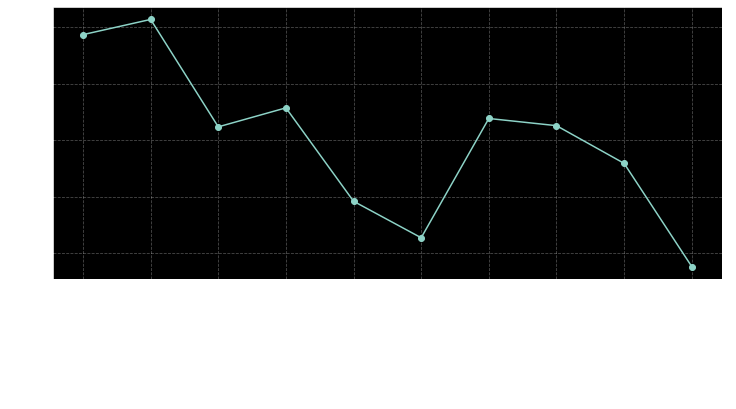

In [48]:
plt.figure(figsize=(12,5))
plt.plot(X_train.columns, model.feature_importance(), '-o')
plt.tick_params(rotation=60, labelsize=16)
plt.grid(ls='--', alpha=0.3)

In [42]:
atom_types   = df_merge.loc[X_test.index.values,"atom"].unique()
atom_colors = ["orange", "r", "m", "y", "b"]
colors = dict([ (nm,catom) for (nm,catom) in zip(atom_types, atom_colors) ])

atom_colors_train = df_merge.loc[X_test.index.values,"atom"].apply(lambda nm: colors[nm]).values

In [49]:
Y_pred = model.predict((X_test-scl_mean)/scl_norm)
Y_pred

array([-0.36123213, -0.26350089,  0.10484893, ...,  0.07232016,
        0.10468013,  0.12417906])

In [46]:
atom_types

array(['C', 'O', 'H', 'N', 'F'], dtype=object)

 --> plotting...
 > MAE = 0.017197271399665915


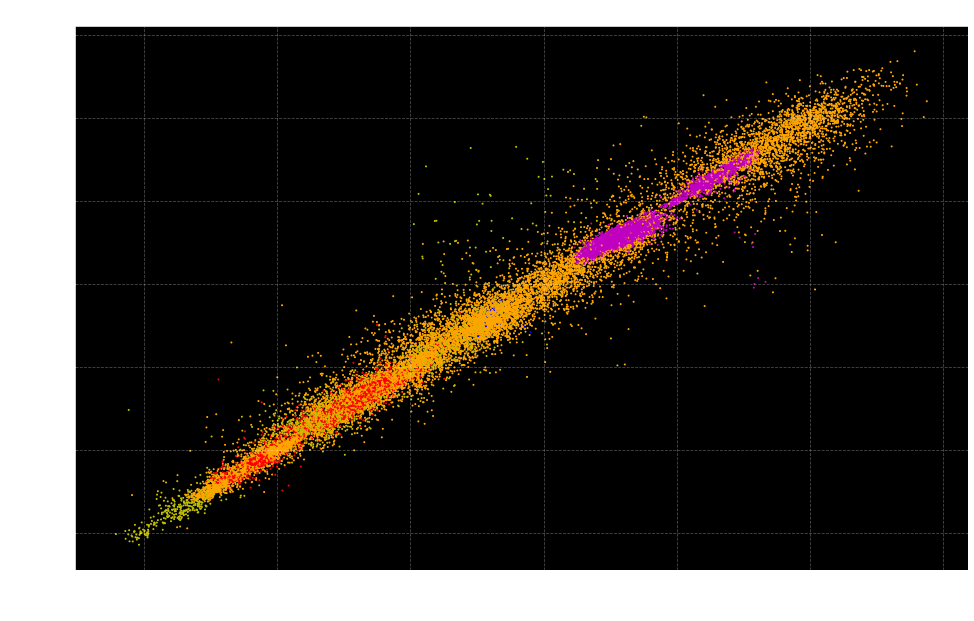

In [50]:
print(" --> plotting...")
plt.figure(figsize=(16,10))
plt.scatter(Y_test, Y_pred, s=1, c=atom_colors_train)
plt.grid(ls='--', alpha=0.3)
plt.title("Mulliken charges", fontsize=18)
plt.xlabel("test", fontsize=18); plt.ylabel("pred", fontsize=18);
plt.tick_params(labelsize=16)

print(" > MAE =", mean_absolute_error(Y_test, Y_pred))